# DataCamp Code-along - Dataset creation

Created by Essalhi Sara
You can run this notebook on a free-tier Google Colab (T4 GPU).

## 1. Introduction

High-quality data is fundamental to produce a good model. The higher the quality, the better the model. In this notebook, we will create a dataset for fine-tuning LLMs.

There are different types of datasets we can use to fine-tune LLMs:

1. **Instruction datasets**: inputs are instructions (e.g., questions) and outputs correspond to the expected responses (e.g., answers). *Example: Open-Orca.*
2. **Raw completion**: this is a continuation of the pre-training objective (next token prediction). In this case, the trained model is not designed to be used as an assistant. *Example: MADLAD-400.*
3. **Preference datasets**: these datasets are used with reinforcement learning to rank candidate responses. They can provide multiple answers to the same instruction, and help the model to select the best response. *Example: ultrafeedback_binarized.*
4. **Others**: a fill-in-the-middle objective is very popular with code completion models (e.g., Codex from GitHub Copilot). Other datasets can be designed for classification, where the outputs correspond to the labels we want to predict (the model requires an additional classfication head in this case).

In practice, supervised fine-tuning only leverages the first type of dataset. We can either **create our own** instruction dataset or **modify an existing one** to filter, improve, or enrich it.



In [1]:
# Install libraries
!pip install -q datasets transformers sentence_transformers faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 44.9 MB/s eta 0:00:00


You can find your token at this address: https://huggingface.co/settings/tokens and copy paste it in the "Secrets" tab in Google Colab (name: "huggingface").

In [2]:
from google.colab import userdata

# Defined in the secrets tab in Google Colab
hf_token = userdata.get('huggingface')

In [3]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("EssalhiSara/french.corpus")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/69927 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['corpus'],
        num_rows: 69927
    })
})

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

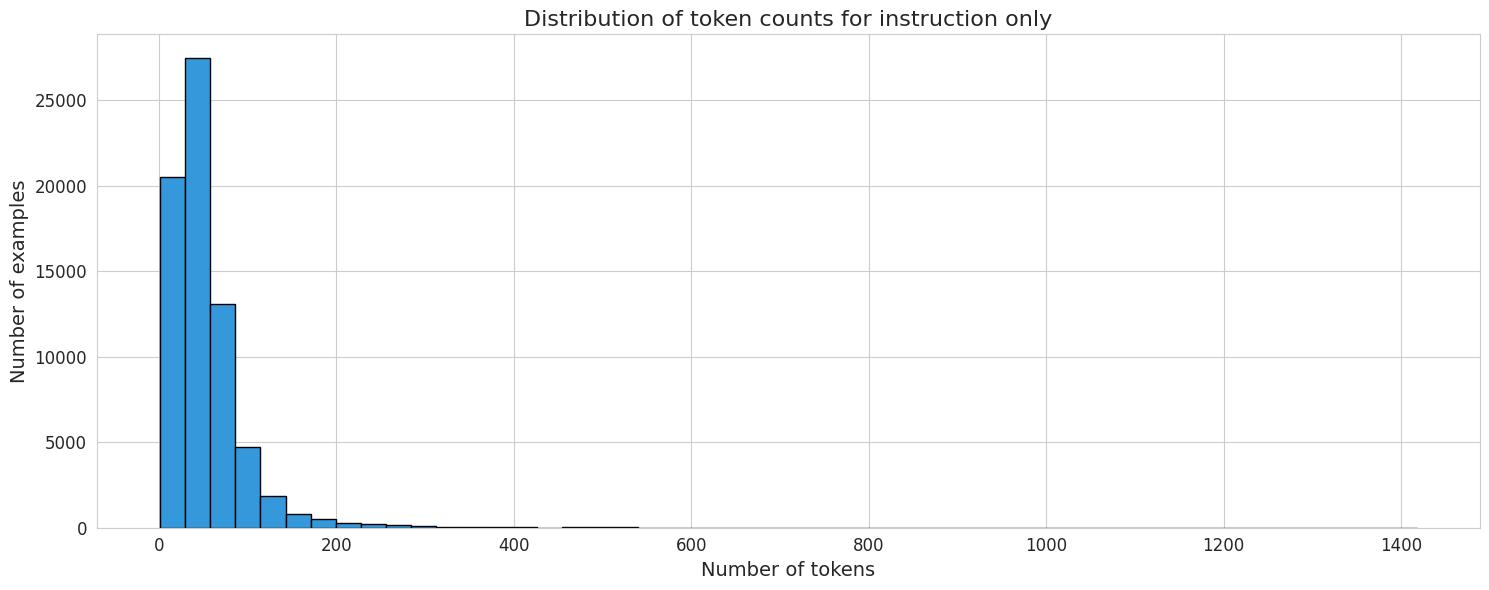

In [7]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf")

# 2. Tokenize each row and count the number of tokens
instruction_token_counts = [len(tokenizer.tokenize(str(example["corpus"]))) for example in dataset['train']]

# Helper function to plot the distributions
def plot_distribution(token_counts, title):
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 6))
    plt.hist(token_counts, bins=50, color='#3498db', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Number of tokens", fontsize=14)
    plt.ylabel("Number of examples", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot the distribution of token counts
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")

## 2. Near-deduplication using embeddings


In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
from datasets import Dataset, DatasetDict
from tqdm.autonotebook import tqdm
import numpy as np

def deduplicate_dataset(dataset: Dataset, model: str, threshold: float):
    sentence_model = SentenceTransformer(model)
    outputs = dataset['train']['corpus']  # Accessing the 'corpus' feature within the 'train' split

    print("Converting text to embeddings...")
    embeddings = sentence_model.encode(outputs, show_progress_bar=True)
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    index.add(normalized_embeddings)

    print("Filtering out near-duplicates...")
    D, I = index.search(normalized_embeddings, k=2)
    to_keep = []

    for i in tqdm(range(len(embeddings)), desc="Filtering"):
        # If the second closest vector (D[i, 1]) has cosine similarity above the threshold
        if D[i, 1] >= threshold:
            # Check if either the current item or its nearest neighbor is already in the to_keep list
            nearest_neighbor = I[i, 1]
            if i not in to_keep and nearest_neighbor not in to_keep:
                # If not, add the current item to the list
                to_keep.append(i)
        else:
            # If the similarity is below the threshold, always keep the current item
            to_keep.append(i)

    deduplicated_dataset = dataset['train'].select(to_keep)  # Selecting examples from the 'train' split
    return DatasetDict({"train": deduplicated_dataset})

# Assuming deduped_dataset is already defined
deduped_dataset = deduplicate_dataset(dataset, "thenlper/gte-large", 0.95)



In [ ]:
# Read as pandas DataFrame
dataset['train'].to_pandas()

,corpus
0,Ce n'est pas le premier roman à aborder les th...
1,"Simple, alias Barnabé, est un jeune homme de 2..."
2,Pour écrire La plus secrète mémoire des hommes...
3,« La violence d'Aurélien est revenue. Par la f...
4,"Dans ce second album de La Guerre d’Alan, Emma..."
...,...
72578,C'est aussi dans cet esprit qu'une certaine fl...
72579,"À ce stade, la vérification ex ante de l'addit..."
72580,"Mais cela n'interdit pas la vigilance, cela n'..."
72581,La plupart des États membres ont transmis les ...


In [ ]:
# Optional: push to Hugging Face Hub
dataset.push_to_hub("french.corpus", token=hf_token)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/73 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/279 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/EssalhiSara/french.corpus/commit/121148fa372915a1948709ad504cd22b42af3a4c', commit_message='Upload dataset', commit_description='', oid='121148fa372915a1948709ad504cd22b42af3a4c', pr_url=None, pr_revision=None, pr_num=None)